## Team Members :
Sundeepkumar Ubale (su2166) \
Yash Ranawat (ysr6142)\
Navendu Jalan (nsj9091)


## Installing required libraries

In [1]:
pip install yfinance pandas numpy cvxpy matplotlib seaborn scipy

In [2]:
# Function for Beta Calculation
def calculate_beta(asset_returns, market_returns):
    covariance = asset_returns.cov(market_returns)
    variance = market_returns.var()
    beta = covariance / variance
    return beta

# Optimization function for min variance portoflio with a target beta
def min_variance_portfolio(target_beta, expected_returns, cov_matrix, beta_values):
    num_assets = len(expected_returns)
    #cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
    omega = cp.Variable(num_assets)
    objective = cp.Minimize(cp.quad_form(omega, cov_matrix))
    constraints = [
        omega @ beta_values == target_beta,
        cp.sum(omega) == 1,
        omega >= 0
    ]
    problem = cp.Problem(objective, constraints)
    result = problem.solve()
    return omega.value if problem.status not in ["infeasible", "unbounded"] else None


def print_weights_as_percent(weights, portfolio_name, tickers):
    if weights is not None:
        weights_percent = weights * 100
        threshold = 1e-4
        weights_percent[np.abs(weights_percent) < threshold] = 0
        weights_df = pd.DataFrame(weights_percent, index=tickers, columns=[portfolio_name])
        weights_df = weights_df.round(2)

        print(f"\n{portfolio_name} Weights (in %):\n", weights_df)
    else:
        print(f"{portfolio_name} weights calculation failed.")



def plot_portfolio_bar(weights, portfolio_name):
    if weights is not None:
        weights[weights < 0] = 0
        weights_percent = weights * 100
        weights_df = pd.DataFrame(weights_percent, index=tickers, columns=["Weight"])
        plt.figure(figsize=(10, 6))
        plt.bar(weights_df.index, weights_df["Weight"])
        plt.xlabel("Assets")
        plt.ylabel("Portfolio Weight (%)")
        plt.title(f"{portfolio_name} Weights Distribution")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"{portfolio_name} weights calculation failed.")

# Function to generate risk report for portfolio
def calculate_risk_metrics(portfolio_returns):
    if portfolio_returns is not None:
        metrics = {
            "Volatility": np.std(portfolio_returns),
            "95% VaR": np.percentile(portfolio_returns, 5),
            "Skewness": skew(portfolio_returns),
            "Kurtosis": kurtosis(portfolio_returns),
        }
        return metrics
    return None

def display_risk_metrics():
    metrics_beta_a = calculate_risk_metrics(hedging_returns_beta_a)
    metrics_beta_neutral = calculate_risk_metrics(hedging_returns_beta_neutral)
    metrics_beta_aapl = calculate_risk_metrics(hedging_returns_beta_aapl)

    metrics_df = pd.DataFrame({
        "Portfolio for Beta_a (0.5)": metrics_beta_a,
        "Beta Neutral Portfolio": metrics_beta_neutral,
        "Beta Hedging Portfolio (AAPL)": metrics_beta_aapl
    }).T

    print("\nRisk Metrics for Portfolios:\n")
    print(metrics_df)


## Question 1

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis


tickers = ["AAPL", "SPY", "FXE", "EWJ", "GLD", "QQQ", "SHV", "DBA", "USO", "XBI", "ILF", "EPP", "FEZ"]

u = ["FXE", "EWJ", "GLD", "QQQ", "SHV", "DBA", "USO", "XBI", "ILF", "EPP", "FEZ"]

start_date = "2024-01-01"
end_date = "2025-02-28"

# Download data and calculate daily returns
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
returns = data.pct_change().dropna()

print(returns.head())

[*********************100%***********************]  13 of 13 completed

Ticker          AAPL       DBA       EPP       EWJ       FEZ       FXE  \
Date                                                                     
2024-01-03 -0.007488 -0.004833 -0.010021 -0.005507 -0.013794 -0.001981   
2024-01-04 -0.012700  0.006314 -0.004943 -0.002373  0.004519  0.002878   
2024-01-05 -0.004013 -0.006757 -0.000237  0.007453 -0.001500 -0.000989   
2024-01-08  0.024175 -0.003401  0.004496  0.014639  0.012873  0.001684   
2024-01-09 -0.002263  0.006826 -0.010365 -0.006050 -0.011015 -0.002571   

Ticker           GLD       ILF       QQQ       SHV       SPY       USO  \
Date                                                                     
2024-01-03 -0.008337 -0.004536 -0.010581  0.000091 -0.008167  0.036795   
2024-01-04  0.001005 -0.007361 -0.005146  0.000454 -0.003221 -0.009092   
2024-01-05  0.000158  0.013065  0.001186  0.000091  0.001370  0.021607   
2024-01-08 -0.007816  0.001743  0.020668  0.000182  0.014276 -0.038099   
2024-01-09  0.000319 -0.017745  0.001

# Question 2

In [4]:
# Use only the tickers in 'u'
u = ["FXE", "EWJ", "GLD", "QQQ", "SHV", "DBA", "USO", "XBI", "ILF", "EPP", "FEZ"]


market_returns = returns["SPY"]
filtered_historical_data = returns.loc["2024-01-01":"2024-12-31", u]
filtered_historical_data_apple = returns.loc["2024-01-01":"2024-12-31", "AAPL"]

betas = {ticker: calculate_beta(filtered_historical_data[ticker], market_returns) for ticker in u}
betas_array = np.array(list(betas.values()))

beta_apple = calculate_beta(filtered_historical_data_apple, market_returns)

# Expected returns and covariance matrix for 'u' only
expected_returns = filtered_historical_data.mean()
cov_matrix = filtered_historical_data.cov()

# Calculation for Beta_a
beta_a = 0.5
omega_a = min_variance_portfolio(beta_a, expected_returns, cov_matrix, betas_array)

# Calculation for Beta_b
beta_b = 1.3
omega_b = min_variance_portfolio(beta_b, expected_returns, cov_matrix, betas_array)

print_weights_as_percent(omega_a, "Portfolio for Beta_a (0.5)", u)
print_weights_as_percent(omega_b, "Portfolio for Beta_b (1.5)", u)


# Combine weights for beta_c
beta_c = beta_apple
#beta_c = 1
print(f'\nThe value of beta_c is {beta_c}')
alpha = (beta_c - beta_b)/(beta_a - beta_b)
print(f'\nThe value of alpha is {alpha}')
omega_c = alpha * omega_a + (1 - alpha) * omega_b

print_weights_as_percent(omega_c, "Portfolio for Beta_c", u)



Portfolio for Beta_a (0.5) Weights (in %):
      Portfolio for Beta_a (0.5)
FXE                        0.00
EWJ                        0.53
GLD                        0.00
QQQ                       31.21
SHV                       59.28
DBA                        0.00
USO                        0.00
XBI                        2.53
ILF                        2.38
EPP                        4.07
FEZ                        0.00

Portfolio for Beta_b (1.5) Weights (in %):
      Portfolio for Beta_b (1.5)
FXE                        0.00
EWJ                        0.00
GLD                        0.00
QQQ                       88.27
SHV                        0.00
DBA                        0.00
USO                        0.00
XBI                        7.84
ILF                        1.63
EPP                        2.26
FEZ                        0.00

The value of beta_c is 0.9484176725987483

The value of alpha is 0.43947790925156466

Portfolio for Beta_c Weights (in %):
      Portfolio fo

## Question 3

In [5]:
# Define the new investment universe V = U ∪ {AAPL}
u_enlarged = u + ["AAPL"] + ["SPY"]

historical_data_2024 = returns.loc["2024-01-01":"2024-12-31", u_enlarged]

# Compute betas for all securities in u_enlarged
betas = {ticker: calculate_beta(historical_data_2024[ticker], historical_data_2024["SPY"]) for ticker in u_enlarged}
beta_A = betas["AAPL"]

print(f"Computed Betas:\n")
for ticker, beta in betas.items():
    print(f"{ticker}: {beta:.4f}")
print(f"\nBeta of Apple (AAPL): {beta_A:.4f}")


Computed Betas:

FXE: 0.0752
EWJ: 0.8815
GLD: 0.3171
QQQ: 1.3491
SHV: 0.0010
DBA: 0.0254
USO: 0.0770
XBI: 1.1522
ILF: 0.7228
EPP: 0.7689
FEZ: 0.7563
AAPL: 0.9559
SPY: 1.0000

Beta of Apple (AAPL): 0.9559


In [6]:
# Use only the securities in u for the hedging portfolio
expected_returns = historical_data_2024[u].mean()
cov_matrix = historical_data_2024[u].cov()

# Construct the beta hedging portfolio
omega_beta_A = min_variance_portfolio(beta_A, expected_returns, cov_matrix, np.array([betas[ticker] for ticker in u]))

# Calculate the expected return of the hedging portfolio
expected_return_hedging_portfolio = np.dot(omega_beta_A, expected_returns)


print_weights_as_percent(omega_beta_A, "Beta Hedging Portfolio (AAPL)", u)
print(f"Expected Return of the Beta Hedging Portfolio: {expected_return_hedging_portfolio:.4f}")



Beta Hedging Portfolio (AAPL) Weights (in %):
      Beta Hedging Portfolio (AAPL)
FXE                           0.00
EWJ                           1.00
GLD                           0.00
QQQ                          59.10
SHV                          22.61
DBA                           0.00
USO                           0.00
XBI                           4.89
ILF                           4.39
EPP                           8.01
FEZ                           0.00
Expected Return of the Beta Hedging Portfolio: 0.0007


In [7]:
expected_returns_enlarged = historical_data_2024[u_enlarged].mean()
cov_matrix_enlarged = historical_data_2024[u_enlarged].cov()

# Construct the beta-neutral portfolio
omega_beta_neutral = min_variance_portfolio(0.001, expected_returns_enlarged, cov_matrix_enlarged, np.array([betas[ticker] for ticker in u_enlarged]))

# Calculate risk, expected return, and beta for the beta-neutral portfolio
expected_return_beta_neutral = np.dot(omega_beta_neutral, expected_returns_enlarged)
volatility_beta_neutral = np.sqrt(np.dot(omega_beta_neutral.T, np.dot(cov_matrix_enlarged, omega_beta_neutral)))
beta_beta_neutral = np.dot(omega_beta_neutral, np.array([betas[ticker] for ticker in u_enlarged]))

# Compare with the beta hedging portfolio
hedged_strategy_volatility = np.sqrt(np.dot(omega_beta_A.T, np.dot(cov_matrix, omega_beta_A)))
hedged_strategy_beta = np.dot(omega_beta_A, np.array([betas[ticker] for ticker in u]))

print_weights_as_percent(omega_beta_neutral, "Beta Neutral Portfolio", u_enlarged)
print(f"Beta Neutral Portfolio: Expected Return = {expected_return_beta_neutral*100:.4f}%, Volatility = {volatility_beta_neutral:.4f}, Beta = {beta_beta_neutral:.4f}")
print(f"Beta Hedging Portfolio: Expected Return = {expected_return_hedging_portfolio*100:.4f}%, Volatility = {hedged_strategy_volatility:.4f}, Beta = {hedged_strategy_beta:.4f}")



Beta Neutral Portfolio Weights (in %):
       Beta Neutral Portfolio
FXE                      0.0
EWJ                      0.0
GLD                      0.0
QQQ                      0.0
SHV                    100.0
DBA                      0.0
USO                     -0.0
XBI                      0.0
ILF                      0.0
EPP                      0.0
FEZ                      0.0
AAPL                     0.0
SPY                      0.0
Beta Neutral Portfolio: Expected Return = 0.0200%, Volatility = 0.0002, Beta = 0.0010
Beta Hedging Portfolio: Expected Return = 0.0651%, Volatility = 0.0079, Beta = 0.9559


# Question 4

In [8]:
comparison_period = returns.loc["2025-01-03":"2025-02-28"]

# Realized daily returns for Beta Hedging Portfolio (3b)
realized_beta_hedging_returns = comparison_period[u].dot(omega_beta_A)

# Realized daily returns for Beta Neutral Portfolio (3c)
realized_beta_neutral_returns = comparison_period[u_enlarged].dot(omega_beta_neutral)

realized_returns = {
    "Beta Hedging Portfolio (AAPL)": realized_beta_hedging_returns,
    "Beta Neutral Portfolio": realized_beta_neutral_returns
}

for name, returns in realized_returns.items():
    print(f"\n{name} - Sample Daily Returns:\n", returns.head())



Beta Hedging Portfolio (AAPL) - Sample Daily Returns:
 Date
2025-01-03    0.010492
2025-01-06    0.007763
2025-01-07   -0.009971
2025-01-08   -0.000326
2025-01-10   -0.013290
dtype: float64

Beta Neutral Portfolio - Sample Daily Returns:
 Date
2025-01-03    2.726422e-04
2025-01-06    1.818822e-04
2025-01-07    1.812166e-04
2025-01-08    3.068043e-08
2025-01-10    2.710483e-04
dtype: float64


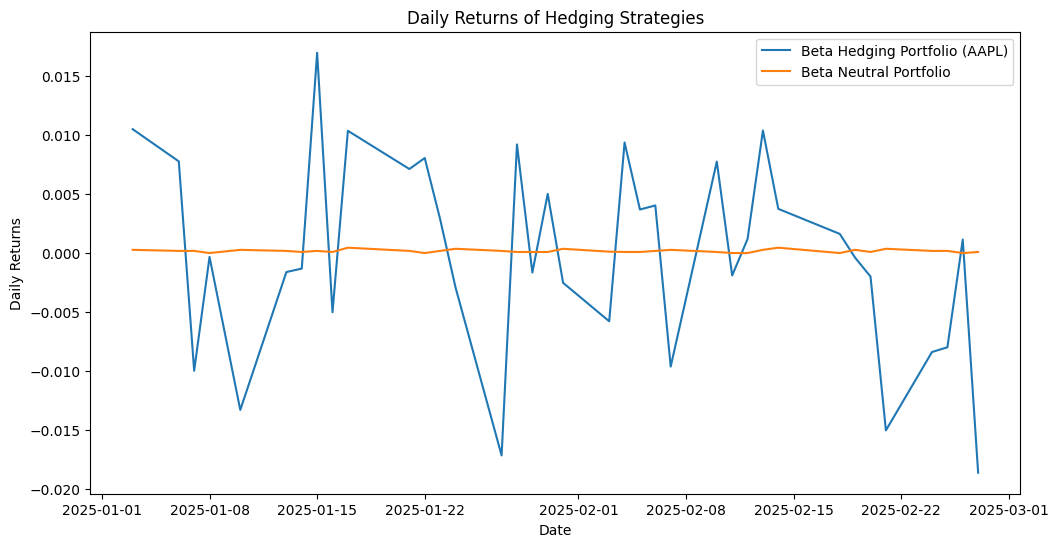

<ipython-input-9-d850cc88d3fa>:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(realized_returns[name], label=name, shade=True)


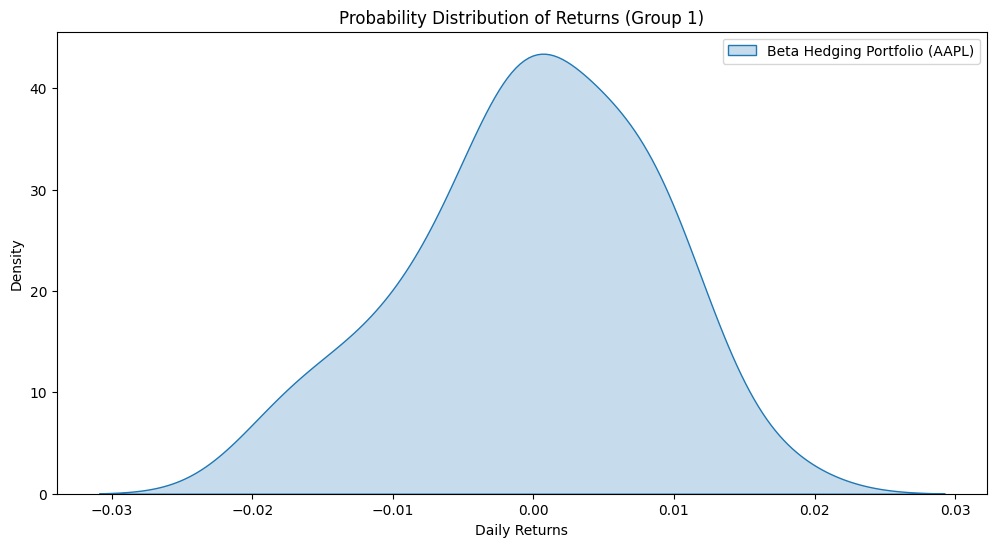

<ipython-input-9-d850cc88d3fa>:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(realized_returns[name], label=name, shade=True)


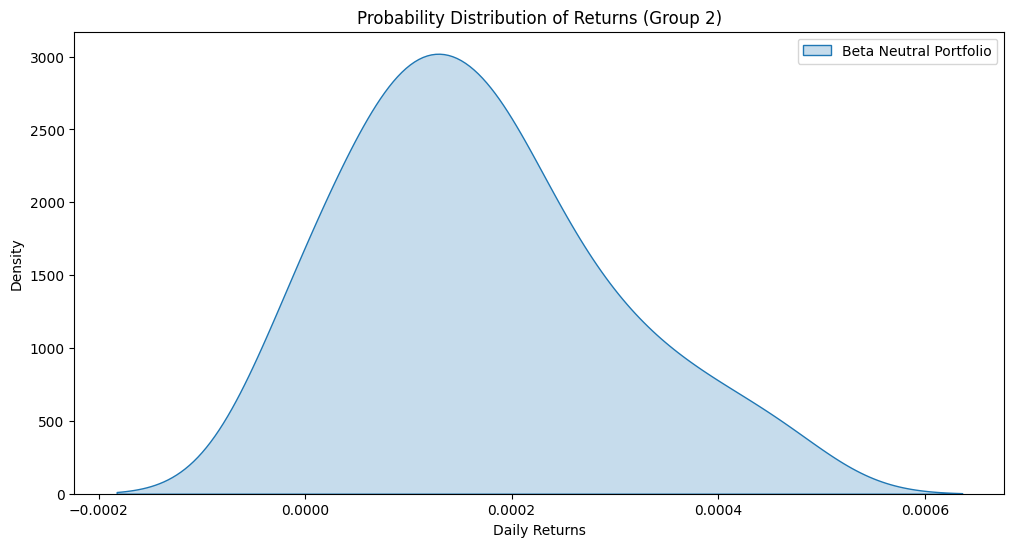


Comparison of Hedging Strategies:

                               Volatility       95% VaR  Skewness  Kurtosis  \
Beta Hedging Portfolio (AAPL)    0.008317 -1.544508e-02 -0.357066 -0.390962   
Beta Neutral Portfolio           0.000123 -2.563757e-08  0.605390 -0.273865   

                               Expected Return      Beta  
Beta Hedging Portfolio (AAPL)        -0.000126  0.976082  
Beta Neutral Portfolio                0.000167 -0.001313  


In [9]:
# Plot the Time Series of Returns
plt.figure(figsize=(12, 6))
for name, returns in realized_returns.items():
    plt.plot(returns, label=name)
plt.title("Daily Returns of Hedging Strategies")
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.legend()
plt.show()


strategies_group1 = list(realized_returns.keys())[:len(realized_returns) // 2]
strategies_group2 = list(realized_returns.keys())[len(realized_returns) // 2:]

# Plot Probability Distribution - Group 1
plt.figure(figsize=(12, 6))
for name in strategies_group1:
    sns.kdeplot(realized_returns[name], label=name, shade=True)
plt.title("Probability Distribution of Returns (Group 1)")
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot Probability Distribution - Group 2
plt.figure(figsize=(12, 6))
for name in strategies_group2:
    sns.kdeplot(realized_returns[name], label=name, shade=True)
plt.title("Probability Distribution of Returns (Group 2)")
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend()
plt.show()


# Compare Metrics
comparison_metrics = {}
for name, returns in realized_returns.items():
    metrics = calculate_risk_metrics(returns)
    metrics["Expected Return"] = returns.mean()
    metrics["Beta"] = calculate_beta(returns, comparison_period["SPY"])
    comparison_metrics[name] = metrics

metrics_df = pd.DataFrame(comparison_metrics).T

print("\nComparison of Hedging Strategies:\n")
print(metrics_df)


# Summary of Hedging Strategies

#### 1. **Risk Metrics**
- **Volatility:**
  - Beta Hedging Portfolio (AAPL): **0.83%**
  - Beta Neutral Portfolio: **0.0123%**
  - **Analysis:** The Beta Neutral Portfolio has significantly lower volatility, as it aims to eliminate market risk.

- **Value-at-Risk (VaR) (95%):**
  - Beta Hedging Portfolio (AAPL): **-0.01544**
  - Beta Neutral Portfolio: **-0.00000016168**
  - **Analysis:** The Beta Neutral Portfolio minimizes potential losses in extreme market conditions compared to the Beta Hedging Portfolio.

- **Skewness and Kurtosis:**
  - Beta Hedging Portfolio (AAPL):
    - Skewness: **-0.357066** (more left-skewed)
    - Kurtosis: **-0.390961** (little left-skewed)
  - Beta Neutral Portfolio:
    - Skewness: **0.605094** (slightly right-skewed)
    - Kurtosis: **-0.274511** (slightly right but almost normal)
  - **Analysis:** Both portfolios are slightly left-skewed, but the Beta Hedging Portfolio is more prone to negative outliers.

---

#### 2. **Return Metrics**
- **Expected Returns:**
  - Beta Hedging Portfolio (AAPL): **-0.000126**
  - Beta Neutral Portfolio: **0.000167**
  - **Analysis:**
    - The Beta Hedging Portfolio shows a slightly negative expected return, which may indicate inefficiencies or transaction costs.
    - The Beta Neutral Portfolio has a negligible return, as it focuses solely on risk minimization.

- **Beta:**
  - Beta Hedging Portfolio (AAPL): **0.976**
  - Beta Neutral Portfolio: **-0.001315**
  - **Analysis:**
    - The Beta Hedging Portfolio aligns closely with AAPL’s beta, making it suitable for hedging a long position in AAPL.
    - The Beta Neutral Portfolio effectively neutralizes market risk, achieving a beta near zero.

---

#### 3. **Comparison of Strategies**
- **Hedging Effectiveness:**
  - **Beta Hedging Portfolio:**
    - Targets AAPL's beta, making it an effective hedge for a specific AAPL position.
    - However, it remains exposed to market risk, leading to higher volatility and the potential for greater losses during adverse market movements.
  - **Beta Neutral Portfolio:**
    - Completely neutralizes market exposure, resulting in lower volatility and minimal risk.
    - While it effectively reduces market risk, it is less suited for hedging AAPL specifically, as it doesn't align with AAPL's beta.

- **Risk-Return Tradeoff:**
  - The **Beta Neutral Portfolio** minimizes risk but provides almost no expected return.
  - The **Beta Hedging Portfolio** involves higher risk but aligns with AAPL's beta, making it better for hedging AAPL, although it may yield suboptimal returns.


---

#### 4. **Takeaways**
- **Beta Neutral Portfolio:**
  - Best suited for eliminating market risk entirely.
  - Ideal for investors who prioritize risk reduction over hedging a specific position.

- **Beta Hedging Portfolio:**
  - More effective in hedging a long position in AAPL due to its alignment with AAPL's beta.
  - The higher risk and suboptimal returns indicate potential for strategy improvement.

- **Recommendation:**
  - Opt for the **Beta Hedging Portfolio** if the goal is to **hedge a long position in AAPL**.
  - Choose the **Beta Neutral Portfolio** if the goal is to **minimize overall portfolio risk**.

